In [1]:
import agama
import arepo
import h5py as h5
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import matplotlib as mpl

from scipy.ndimage import gaussian_filter

from numba import njit

agama.setUnits(mass=1E10, length=1, velocity=1)

'Length unit: 1 Kpc, velocity unit: 1 km/s, time unit: 977.793 Myr, mass unit: 1e+10 Msun, gravitational constant: 43009.2'

In [2]:
@njit
def my_mult(mass, vel):
    out = np.zeros((len(mass), 3))
    for i in range(len(mass)):
        out[i][0] = mass[i] * vel[i][0] 
        out[i][1] = mass[i] * vel[i][1]
        out[i][2] = mass[i] * vel[i][2]
    return out

In [3]:
sim_list = ['Nbody', 'phantom-vacuum-Sg20-Rc3.5']

basepath = '/n/holystore01/LABS/hernquist_lab/Users/abeane/starbar_runs/runs/'

def read_snap(idx, sim_idx, lvl='lvl3', parttype=[0], fields=['Coordinates', 'Masses', 'Velocities', 'ParticleIDs', 'Potential'],
              basepath = basepath):
    fname = basepath + sim_list[sim_idx] + '/' + lvl + '/output'
    return arepo.Snapshot(fname, idx, parttype=parttype, fields=fields, combineFiles=True)

def read_sfr(sim_idx, lvl='lvl3', basepath = basepath):
    fname = basepath + sim_list[sim_idx] + '/' + lvl + '/output/sfr.txt'
    return np.genfromtxt(fname)

def read_fourier(sim_idx, lvl='lvl3', basepath='/n/home01/abeane/starbar/plots/'):
    sim = sim_list[sim_idx]
    f = h5.File(basepath+'/fourier_component/data/fourier_'+sim+'-'+lvl+'.hdf5', mode='r')
    return f

In [5]:
@njit 
def compute_surface_density(R, mass, Rbins):
    key = np.where(R < Rbins[-1])[0]
    R = R[key]
    
    surf_dens = np.zeros(len(Rbins)-1)
    ave_R = np.zeros(len(Rbins)-1)
    N_in_bin = np.zeros(len(Rbins)-1)
    
    for i in range(len(R)):
        for j in range(len(Rbins)-1):
            if R[i] >= Rbins[j] and R[i] < Rbins[j+1]:
                ave_R[j] += R[i]
                N_in_bin[j] += 1
                surf_dens[j] += mass
    
    for j in range(len(Rbins)-1):
        if N_in_bin[j] > 0:
            ave_R[j] /= N_in_bin[j]
            surf_dens[j] /= np.pi * (Rbins[j+1]**2 - Rbins[j]**2)
        else:
            ave_R[j] = np.nan
            surf_dens[j] = np.nan
    
    return ave_R, surf_dens

def compute_surface_density_from_sn(sn, Rbins, center=np.array([0., 0., 0.])):
    
    halo_pos = sn.part1.pos.value - center
    halo_mass = sn.MassTable[1]

    R = np.linalg.norm(halo_pos[:,:2], axis=1)

    ave_R, surf_dens = compute_surface_density(R, halo_mass, Rbins)
    
    return ave_R, surf_dens
    

In [16]:
sn = read_snap(500, 0, parttype=[1, 2])
sn600 = read_snap(600, 0, parttype=[1, 2])
sn0 = read_snap(0, 0, lvl='lvl3', parttype=[0, 1, 2])

In [6]:
center = np.array([200., 200., 200.])
halo_pos = sn.part1.pos.value
# halo_pos400 = sn.part1.pos.value - center
# halo_pos0 = sn0.part1.pos.value - center
disk_pos = sn.part2.pos.value

In [121]:
key = np.where(np.abs(halo_pos[:,2]) < 2)
halo_pos_thin = halo_pos[key]

# key = np.where(np.abs(halo_pos400[:,2]) < 2)
# halo_pos_thin400 = halo_pos400[key]

# key = np.where(np.abs(halo_pos0[:,2]) < 2)
# halo_pos_thin0 = halo_pos0[key]

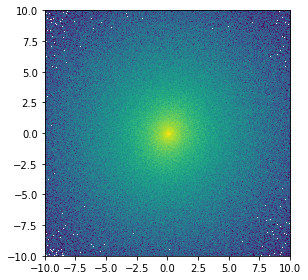

In [124]:
nres = 256

range_xy = [[-10, 10], [-10, 10]]

x = halo_pos_thin[:,0]
y = halo_pos_thin[:,1]
heatmap_xy, _, _ = np.histogram2d(x, y, bins=(nres, nres), range=range_xy)

extent = [range_xy[0][0], range_xy[0][1], range_xy[1][0], range_xy[1][1]]

fig, ax = plt.subplots(1, 1)

ax.imshow(heatmap_xy.T, extent=extent, origin='lower', norm=mpl.colors.LogNorm())
ax.set_aspect('equal')
fig.tight_layout()

plt.show()


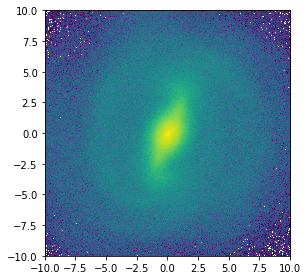

In [127]:
nres = 512

range_xy = [[-10, 10], [-10, 10]]

x = disk_pos[:,0]
y = disk_pos[:,1]
heatmap_xy, _, _ = np.histogram2d(x, y, bins=(nres, nres), range=range_xy)

extent = [range_xy[0][0], range_xy[0][1], range_xy[1][0], range_xy[1][1]]

fig, ax = plt.subplots(1, 1)

ax.imshow(heatmap_xy.T, extent=extent, origin='lower', norm=mpl.colors.LogNorm())
ax.set_aspect('equal')
fig.tight_layout()

plt.show()


In [138]:
Rbins = np.linspace(0, 15, 30)
R = np.linalg.norm(halo_pos_thin[:,:2], axis=1)
mass = sn.MassTable[1]
ave_R, surf = compute_surface_density(R, mass, Rbins)


In [139]:
from scipy.interpolate import interp1d
surf_interp = interp1d(ave_R, surf, fill_value='extrapolate')

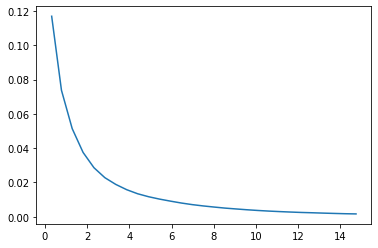

In [140]:
plt.plot(ave_R, surf)
plt.show()

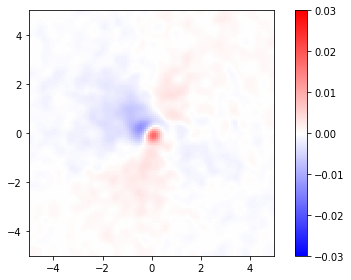

In [144]:
nres = 128

range_xy = [[-5, 5], [-5, 5]]

x = halo_pos_thin[:,0]
y = halo_pos_thin[:,1]
# x = halo_pos400[:,0]
# y = halo_pos400[:,1]

heatmap_xy, xbins, ybins = np.histogram2d(x, y, bins=(nres, nres), range=range_xy)
dx = (range_xy[0][1] - range_xy[0][0])/nres
heatmap_xy /= dx*dx/sn.MassTable[1]

ave_x = (xbins[:-1] + xbins[1:])/2.0
ave_y = (ybins[:-1] + ybins[1:])/2.0
xgrid, ygrid = np.meshgrid(ave_x, ave_y, indexing='ij')
Rgrid = np.sqrt(xgrid * xgrid + ygrid * ygrid)
surf_grid = surf_interp(Rgrid)

heatmap_xy -= surf_grid

heatmap_xy = gaussian_filter(heatmap_xy, sigma=2)


extent = [range_xy[0][0], range_xy[0][1], range_xy[1][0], range_xy[1][1]]

fig, ax = plt.subplots(1, 1)

im = ax.imshow(heatmap_xy.T, extent=extent, origin='lower', vmin=-0.03, vmax=0.03, cmap='bwr')#, norm=mpl.colors.LogNorm())
ax.set_aspect('equal')
fig.colorbar(im, ax=ax)
fig.tight_layout()

plt.show()


## E-Lz Plots

In [28]:
def compute_E_Lz_dLz(sn0, sn1, center=np.array([0., 0., 0.])):
    key_sort = np.argsort(sn0.part1.id)
    
    pos_halo = sn0.part1.pos.value[key_sort] - center
    vel_halo = sn0.part1.vel.value[key_sort]
    pot_halo = sn0.part1.pot.value[key_sort]

    vsq = np.square(np.linalg.norm(vel_halo, axis=1))
    Ehalo = 0.5 * vsq + pot_halo
    Lz_halo = sn0.MassTable[1] * np.cross(pos_halo, vel_halo)[:,2]

    key_sort = np.argsort(sn1.part1.id)
    pos_halo1 = sn1.part1.pos.value[key_sort] - center
    vel_halo1 = sn1.part1.vel.value[key_sort]
    pot_halo1 = sn1.part1.pot.value[key_sort]
    
    Lz1 = sn0.MassTable[1] * np.cross(pos_halo1, vel_halo1)[:,2]

    dLz = Lz1 - Lz_halo
    
    return Ehalo, Lz_halo, dLz
    
def make_E_Lz_dLz_plot(ax, Ehalo, Lz_halo, dLz, mass=3.75019313e-06):
    
    nres = 256

    range_xy = [[-1.5, 0], [-2000, 2000]]

#     E_ave, Lz_max = compute_max_Lz(Ehalo, Lz_halo)
#     Lz_interp = interp1d(E_ave, Lz_max, fill_value='extrapolate')
#     y = Lz_halo / Lz_interp(Ehalo)
    
    x = Ehalo*mass
    y = Lz_halo/mass
    heatmap_xy, _, _ = np.histogram2d(x, y, bins=(nres, nres), weights=dLz/mass, range=range_xy)
    N_in_bin, _, _ = np.histogram2d(x, y, bins=(nres, nres), range=range_xy)
    
    heatmap_xy /= N_in_bin
    heatmap_xy[N_in_bin==0] = 0.0
    
#     heatmap_xy = gaussian_filter(heatmap_xy, sigma=1)
    

    dx = (range_xy[0][1] - range_xy[0][0])/nres
    dy = (range_xy[1][1] - range_xy[1][0])/nres
    heatmap_xy /= dx * dy

    extent = [range_xy[0][0], range_xy[0][1], range_xy[1][0], range_xy[1][1]]

#     fig, ax = plt.subplots(1, 1)

    im = ax.imshow(heatmap_xy.T, extent=extent, origin='lower', vmin=-300, vmax=300, cmap='bwr')
    ax.set_aspect('auto')
#     fig.tight_layout()
#     fig.colorbar(im, ax=ax)

#     plt.show()
    
    return im

def make_mass_dens_plot(Ehalo, Lz_halo, mass=3.75019313e-06):
    
    nres = 256

    range_xy = [[-1.5, 0], [-2000, 2000]]

    x = Ehalo*mass
    y = Lz_halo/mass
    heatmap_xy, _, _ = np.histogram2d(x, y, bins=(nres, nres), range=range_xy)

    dx = (range_xy[0][1] - range_xy[0][0])/nres
    dy = (range_xy[1][1] - range_xy[1][0])/nres
    heatmap_xy /= dx * dy

    extent = [range_xy[0][0], range_xy[0][1], range_xy[1][0], range_xy[1][1]]

    fig, ax = plt.subplots(1, 1)

    im = ax.imshow(heatmap_xy.T, extent=extent, origin='lower', vmin=10, vmax=1E5, norm=mpl.colors.LogNorm())#, vmin=-0.5, vmax=0.5, cmap='bwr')
    ax.set_aspect('auto')
    fig.tight_layout()
    fig.colorbar(im, ax=ax)

    plt.show()
    
    return fig, ax

In [9]:
Nidx_list = [500, 600, 700, 800]
Sidx_list = [100, 200, 300, 400]

snN_list = []
snS_list = []

for i in tqdm(range(len(Nidx_list))):
    snN_list.append(read_snap(Nidx_list[i], 0, parttype=[1, 2]))
    snS_list.append(read_snap(Sidx_list[i], 1, parttype=[1, 2]))
    

A Jupyter Widget

In [39]:
ENlist, LzNlist, dLzNlist = [], [], []
ESlist, LzSlist, dLzSlist = [], [], []

for i in tqdm(range(len(Nidx_list)-1)):
    E, Lz, dLz = compute_E_Lz_dLz(snN_list[i], snN_list[i+1])
    ENlist.append(E)
    LzNlist.append(Lz)
    dLzNlist.append(dLz)
    
    E, Lz, dLz = compute_E_Lz_dLz(snS_list[i], snS_list[i+1], center=np.array([200., 200., 200.]))
    ESlist.append(E)
    LzSlist.append(Lz)
    dLzSlist.append(dLz)

E, Lz, dLz = compute_E_Lz_dLz(snN_list[3], snN_list[3])
ENlist.append(E)
LzNlist.append(Lz)
dLzNlist.append(dLz)

E, Lz, dLz = compute_E_Lz_dLz(snS_list[3], snS_list[3], center=np.array([200., 200., 200.]))
ESlist.append(E)
LzSlist.append(Lz)
dLzSlist.append(dLz)
    

A Jupyter Widget

/n/helmod/apps/centos7/Core/Anaconda3/5.0.1-fasrc02/x/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in true_divide


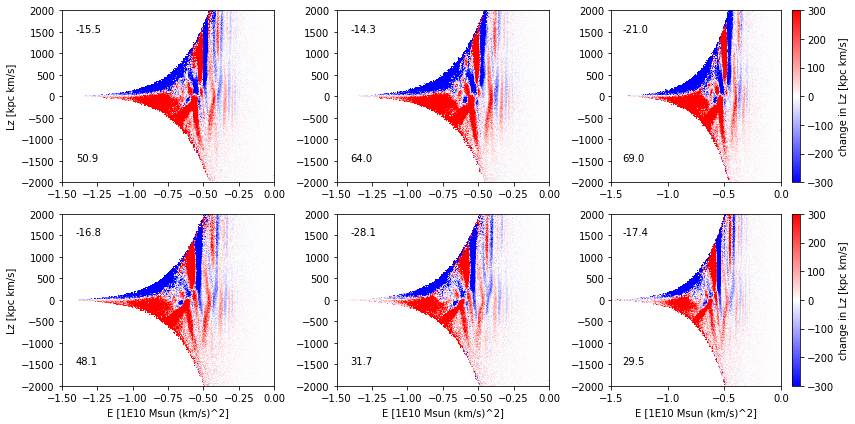

In [34]:
fig, ax = plt.subplots(2, 3, figsize=(12, 6))

for i in range(3):
    x = ax[0][i]
#     E, Lz, dLz = compute_E_Lz_dLz(snN_list[i], snN_list[i+1])
    E, Lz, dLz = ENlist[i], LzNlist[i], dLzNlist[i]
    im = make_E_Lz_dLz_plot(x, E, Lz, dLz)
    
    if i==2:
        fig.colorbar(im, ax=x, label='change in Lz [kpc km/s]')
    
    x.text(-1.4, -1500, "{:.1f}".format(np.sum(dLz[Lz<0])))
    x.text(-1.4, 1500, "{:.1f}".format(np.sum(dLz[Lz>0])))
    
    x = ax[1][i]
#     E, Lz, dLz = compute_E_Lz_dLz(snS_list[i], snS_list[i+1])
    E, Lz, dLz = ESlist[i], LzSlist[i], dLzSlist[i]
    im = make_E_Lz_dLz_plot(x, E, Lz, dLz)
    
    if i==2:
        fig.colorbar(im, ax=x, label='change in Lz [kpc km/s]')
    
    x.text(-1.4, -1500, "{:.1f}".format(np.sum(dLz[Lz<0])))
    x.text(-1.4, 1500, "{:.1f}".format(np.sum(dLz[Lz>0])))

for x in ax[1]:
    x.set_xlabel('E [1E10 Msun (km/s)^2]')
ax[0][0].set_ylabel('Lz [kpc km/s]')
ax[1][0].set_ylabel('Lz [kpc km/s]')

fig.tight_layout()
plt.show()


In [26]:
"{0:.1t67cv f}".format(np.sum(dLz[Lz<0]))

'29.5'

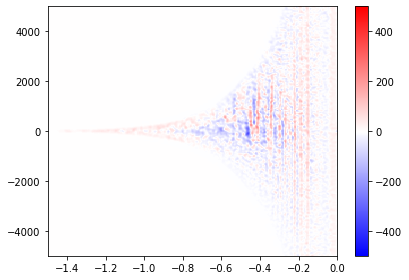

In [32]:
if True:
    mass = snN0.MassTable[1]
    nres = 256

    range_xy = [[-1.5, 0], [-5000, 5000]]

    x = ES*mass
    y = LzS/mass
    heatmap_xy, _, _ = np.histogram2d(x, y, bins=(nres, nres), range=range_xy)
    
    x = ES_e*mass
    y = LzS_e/mass
    heatmap_xy_e,_, _ = np.histogram2d(x, y, bins=(nres, nres), range=range_xy)

    dhmp = heatmap_xy - heatmap_xy_e
    
    dx = (range_xy[0][1] - range_xy[0][0])/nres
    dy = (range_xy[1][1] - range_xy[1][0])/nres
    dhmp /= dx * dy
    
    dhmp = gaussian_filter(dhmp, sigma=1)

    extent = [range_xy[0][0], range_xy[0][1], range_xy[1][0], range_xy[1][1]]

    fig, ax = plt.subplots(1, 1)

    im = ax.imshow(dhmp.T, extent=extent, origin='lower', vmin=-500, vmax=500, cmap='bwr')#, vmin=1E-4, vmax=1E-1, norm=mpl.colors.LogNorm())#, vmin=-0.5, vmax=0.5, cmap='bwr')
    ax.set_aspect('auto')
    fig.tight_layout()
    fig.colorbar(im, ax=ax)

    plt.show()
    
#     return fig, ax

In [44]:
def make_drho_plot(ax, E0, E1, Lz0, Lz1, mass=3.75019313e-06):
    nres = 256

    range_xy = [[-1.5, 0], [-2000, 2000]]

    x = E1*mass
    y = Lz1/mass
    heatmap_xy, _, _ = np.histogram2d(x, y, bins=(nres, nres), range=range_xy)
    
    x = E0*mass
    y = Lz0/mass
    heatmap_xy_e,_, _ = np.histogram2d(x, y, bins=(nres, nres), range=range_xy)

    dhmp = heatmap_xy - heatmap_xy_e
    
    dx = (range_xy[0][1] - range_xy[0][0])/nres
    dy = (range_xy[1][1] - range_xy[1][0])/nres
    dhmp /= dx * dy
    
    dhmp = gaussian_filter(dhmp, sigma=1)

    extent = [range_xy[0][0], range_xy[0][1], range_xy[1][0], range_xy[1][1]]

#     fig, ax = plt.subplots(1, 1)

    im = ax.imshow(dhmp.T, extent=extent, origin='lower', vmin=-500, vmax=500, cmap='bwr')#, vmin=1E-4, vmax=1E-1, norm=mpl.colors.LogNorm())#, vmin=-0.5, vmax=0.5, cmap='bwr')
    ax.set_aspect('auto')
#     fig.colorbar(im, ax=ax)
    
#     ax.set(xlabel='E [(km/s)^2]', ylabel='Lz [kpc km/s]')
    
#     fig.tight_layout()

#     plt.show()
    
    return im

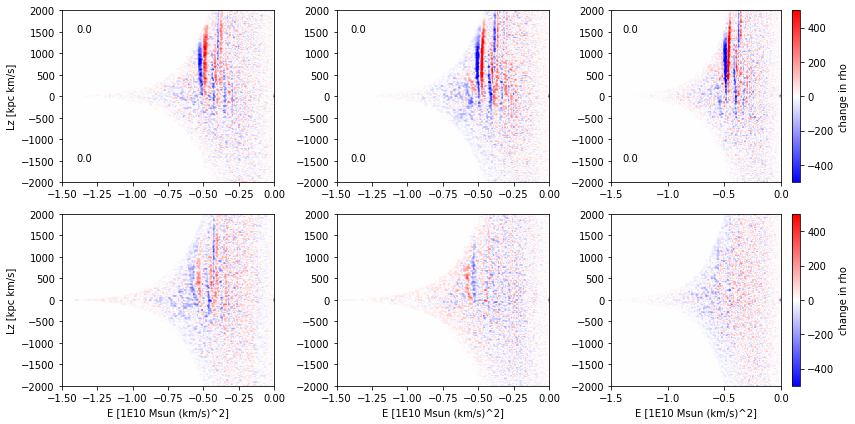

In [45]:
fig, ax = plt.subplots(2, 3, figsize=(12, 6))

for i in range(3):
    x = ax[0][i]
#     E, Lz, dLz = compute_E_Lz_dLz(snN_list[i], snN_list[i+1])
    E0, Lz0 = ENlist[i], LzNlist[i]
    E1, Lz1 = ENlist[i+1], LzNlist[i+1]
    im = make_drho_plot(x, E0, E1, Lz0, Lz1)
    
    if i==2:
        fig.colorbar(im, ax=x, label='change in rho')
    
    x.text(-1.4, -1500, "{:.1f}".format(np.sum(dLz[Lz<0])))
    x.text(-1.4, 1500, "{:.1f}".format(np.sum(dLz[Lz>0])))
    
    x = ax[1][i]
#     E, Lz, dLz = compute_E_Lz_dLz(snS_list[i], snS_list[i+1])
    E0, Lz0 = ESlist[i], LzSlist[i]
    E1, Lz1 = ESlist[i+1], LzSlist[i+1]
    im = make_drho_plot(x, E0, E1, Lz0, Lz1)
    
    if i==2:
        fig.colorbar(im, ax=x, label='change in rho')
    
#     x.text(-1.4, -1500, "{:.1f}".format(np.sum(dLz[Lz<0])))
#     x.text(-1.4, 1500, "{:.1f}".format(np.sum(dLz[Lz>0])))

for x in ax[1]:
    x.set_xlabel('E [1E10 Msun (km/s)^2]')
ax[0][0].set_ylabel('Lz [kpc km/s]')
ax[1][0].set_ylabel('Lz [kpc km/s]')

fig.tight_layout()
plt.show()
